###1. 데이터 전처리

1.1. 라이브러리 임포트

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder 
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import joblib

2024-08-21 00:20:18.234164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 00:20:18.359325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 00:20:18.412252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 00:20:18.427277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 00:20:18.513848: I tensorflow/core/platform/cpu_feature_guar

1.2. 데이터 불러오기

In [2]:
# 데이터 경로
data_path = '/home/tone/data/Human_vital_signs_R.csv'

# 데이터 불러오기
data = pd.read_csv(data_path)

# 데이터 확인
data

,Unnamed: 0,Time (s),HR(BPM),RESP(BPM),SpO2(%),TEMP (*C),OUTPUT
0,0,0,94.0,21.0,97.0,36.2,Normal
1,1,1,94.0,25.0,97.0,36.2,Normal
2,2,2,101.0,25.0,93.0,38.0,Abnormal
3,3,3,55.0,11.0,100.0,35.0,Abnormal
4,4,4,93.0,26.0,95.0,37.0,Normal
...,...,...,...,...,...,...,...
25488,476,476,56.0,12.0,101.0,33.0,Abnormal
25489,477,477,94.0,25.0,98.0,36.4,Normal
25490,478,478,94.0,21.0,97.0,36.2,Normal
25491,479,479,93.0,27.0,95.0,37.0,Normal


In [3]:
# 불필요한 열 제거
data = data.drop(columns=['Unnamed: 0'])

# 각 열의 NaN 값 개수와 비율 확인
nan_counts = data.isna().sum()
nan_percentage = (nan_counts / len(data)) * 100

print("NaN 값 개수:")
print(nan_counts)

print("\nNaN 값 비율 (%):")
print(nan_percentage)

NaN 값 개수:
Time (s)       0
HR(BPM)        5
RESP(BPM)    147
SpO2(%)      127
TEMP (*C)      0
OUTPUT         0
dtype: int64

NaN 값 비율 (%):
Time (s)     0.000000
HR(BPM)      0.019613
RESP(BPM)    0.576629
SpO2(%)      0.498176
TEMP (*C)    0.000000
OUTPUT       0.000000
dtype: float64


In [4]:
# 숫자형 열만 선택하여 결측치를 평균값으로 대체
numeric_columns = data.select_dtypes(include=[np.number]).columns
data_filled = data.copy()
data_filled[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# 결측치 대체 후 NaN 값 개수 확인
nan_counts_after = data_filled.isna().sum()
print("결측치 대체 후 NaN 값 개수:")
print(nan_counts_after)

결측치 대체 후 NaN 값 개수:
Time (s)     0
HR(BPM)      0
RESP(BPM)    0
SpO2(%)      0
TEMP (*C)    0
OUTPUT       0
dtype: int64


1.3. 클래스분포확인

Class distribution:
OUTPUT
Abnormal    19702
Normal       5791
Name: count, dtype: int64


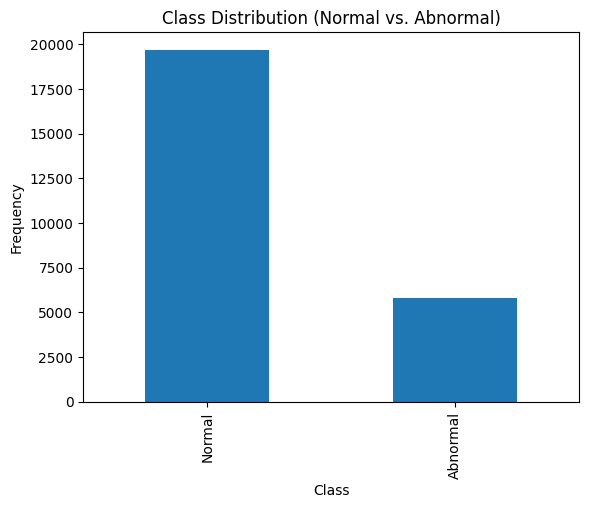

In [5]:
# 각 클래스의 Output 샘플 수 확인
class_counts = data_filled['OUTPUT'].value_counts()

print("Class distribution:")
print(class_counts)

# 클래스 분포를 시각화
class_counts.plot(kind='bar')
plt.title('Class Distribution (Normal vs. Abnormal)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Abnormal'])
plt.show()

###2. 시각화

2.1. 비정상 상태의 생체 신호 분포 시각화

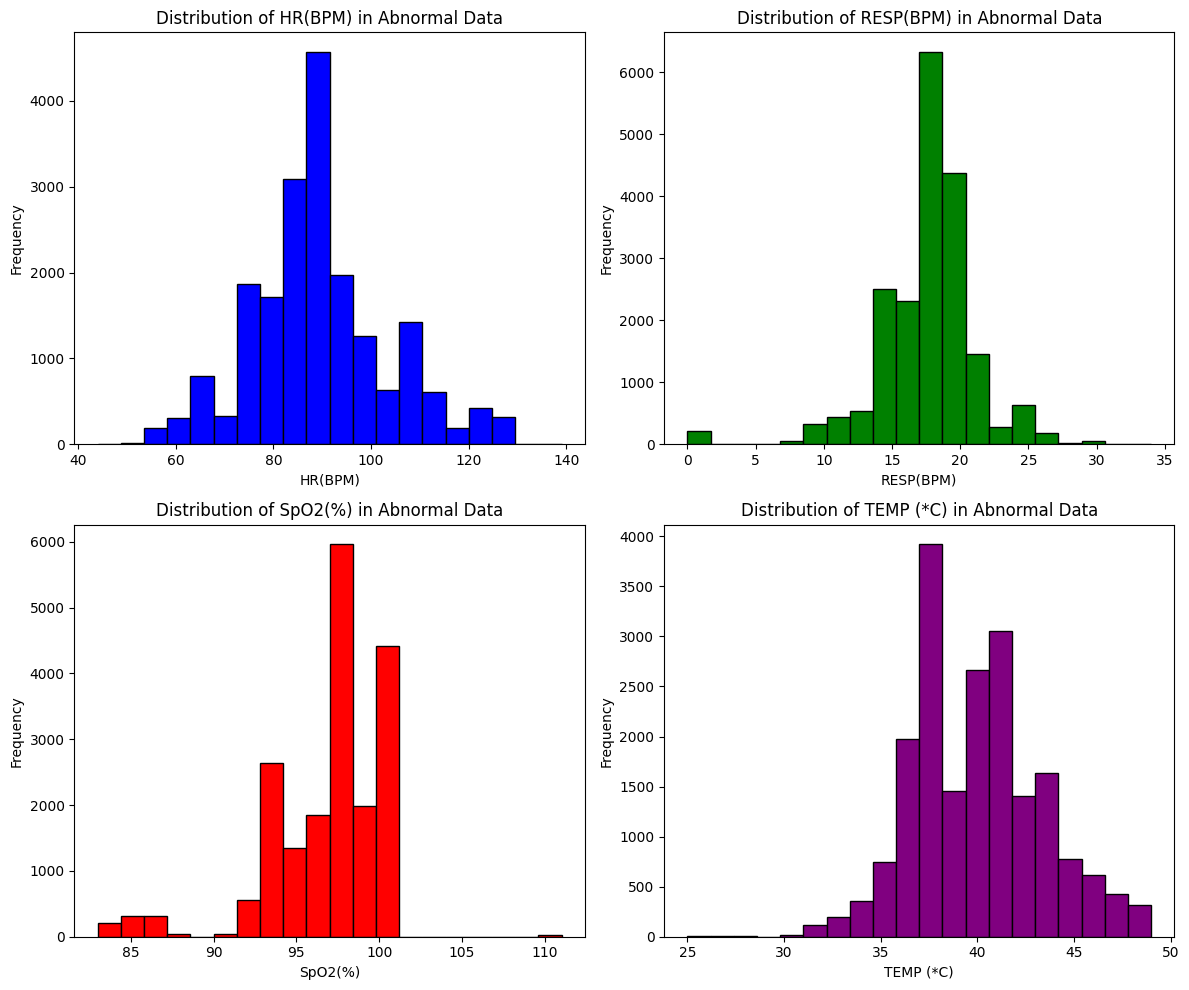

In [6]:
# 비정상 상태 데이터만 필터링
abnormal_data = data_filled[data_filled['OUTPUT'] == 'Abnormal']

# 히스토그램을 통해 비정상 상태의 생체 신호 분포 시각화
plt.figure(figsize=(12, 10))

# 심박수 분포
plt.subplot(2, 2, 1)
plt.hist(abnormal_data['HR(BPM)'], bins=20, color='blue', edgecolor='black')
plt.title('Distribution of HR(BPM) in Abnormal Data')
plt.xlabel('HR(BPM)')
plt.ylabel('Frequency')

# 호흡수 분포
plt.subplot(2, 2, 2)
plt.hist(abnormal_data['RESP(BPM)'], bins=20, color='green', edgecolor='black')
plt.title('Distribution of RESP(BPM) in Abnormal Data')
plt.xlabel('RESP(BPM)')
plt.ylabel('Frequency')

# 산소포화도 분포
plt.subplot(2, 2, 3)
plt.hist(abnormal_data['SpO2(%)'], bins=20, color='red', edgecolor='black')
plt.title('Distribution of SpO2(%) in Abnormal Data')
plt.xlabel('SpO2(%)')
plt.ylabel('Frequency')

# 체온 분포
plt.subplot(2, 2, 4)
plt.hist(abnormal_data['TEMP (*C)'], bins=20, color='purple', edgecolor='black')
plt.title('Distribution of TEMP (*C) in Abnormal Data')
plt.xlabel('TEMP (*C)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

2.2. 상관관계 분석 시각화

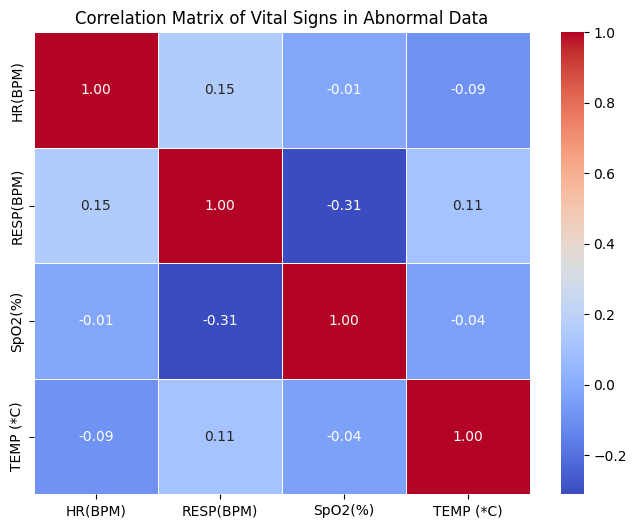

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 비정상 상태 데이터만 필터링
abnormal_data = data[data['OUTPUT'] == 'Abnormal']

# 주요 생체 신호 간의 상관관계 계산
correlation_matrix = abnormal_data[['HR(BPM)', 'RESP(BPM)', 'SpO2(%)', 'TEMP (*C)']].corr()

# 상관관계 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Vital Signs in Abnormal Data')
plt.show()

###3. LSTM 모델링

3.1. 타겟 변수 생성 및 데이터 준비

In [8]:
# 라벨 인코딩
label_encoder = LabelEncoder()
data_filled['OUTPUT'] = label_encoder.fit_transform(data_filled['OUTPUT'])

# 비정상 상태 데이터를 사용해 타겟 변수를 생성 (1: Abnormal, 0: Normal)

data_filled['TARGET'] = data_filled['OUTPUT']  # 직접적으로 TARGET 열에 OUTPUT 열 값을 복사합니다.

# 입력 변수 선택
features = ['HR(BPM)', 'RESP(BPM)', 'SpO2(%)', 'TEMP (*C)']

# 스케일링 적용
scaler = StandardScaler()
X = data_filled[features].values
X_scaled = scaler.fit_transform(X)

In [9]:
# 스케일러 저장
joblib.dump(scaler, 'models/scaler.pkl')

['models/scaler.pkl']

In [10]:
# y (타겟) 변수 정의
y = data_filled['TARGET'].values

# 시계열 데이터 준비 함수 정의
def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# X (생체 신호)와 y (타겟)를 정의
X = data_filled[features].values
y = data_filled['TARGET'].values

# 시계열 데이터 생성
time_steps = 5
X_seq, y_seq = create_sequences(X, y, time_steps)

# 데이터셋을 훈련과 테스트로 분할
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

3.2. LSTM 모델 정의 및 학습

In [12]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
# LSTM 모델 정의
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])# 이진 분류 binary 선택



In [13]:
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Train data shape: (17841, 5, 4)
Test data shape: (7647, 5, 4)


In [14]:

# EarlyStopping과 ModelCheckpoint 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# GPU 사용 여부 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and will be used for training.")
    print(f"Available GPU: {gpus}")
else:
    print("GPU is not available. Training will use CPU.")

# 모델 학습
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# 테스트 데이터로 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


GPU is available and will be used for training.
Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/100


2024-08-21 00:21:14.195055: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7789 - loss: 0.5056 - val_accuracy: 0.8033 - val_loss: 0.4240
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7921 - loss: 0.4565 - val_accuracy: 0.8064 - val_loss: 0.4147
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7881 - loss: 0.4493 - val_accuracy: 0.8050 - val_loss: 0.3928
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7956 - loss: 0.4169 - val_accuracy: 0.8033 - val_loss: 0.3851
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8020 - loss: 0.3994 - val_accuracy: 0.8069 - val_loss: 0.3735
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8003 - loss: 0.4009 - val_accuracy: 0.8098 - val_loss: 0.3683
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8066 - loss: 0.3935 - val_accuracy: 0.8112 - val_loss: 0.3644
Epoch 8/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8081 - loss: 0.3851 - val_accuracy: 0.813

3.3. 예측 및 성능 평가

In [15]:
# 예측 결과 분석
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5871
           1       0.77      0.56      0.65      1776

    accuracy                           0.86      7647
   macro avg       0.82      0.75      0.78      7647
weighted avg       0.85      0.86      0.85      7647



Precision: 0.77
Recall: 0.56
F1 Score: 0.65
ROC-AUC: 0.75
              precision    recall  f1-score   support

      normal       0.88      0.95      0.91      5871
    abnormal       0.77      0.56      0.65      1776

    accuracy                           0.86      7647
   macro avg       0.82      0.75      0.78      7647
weighted avg       0.85      0.86      0.85      7647



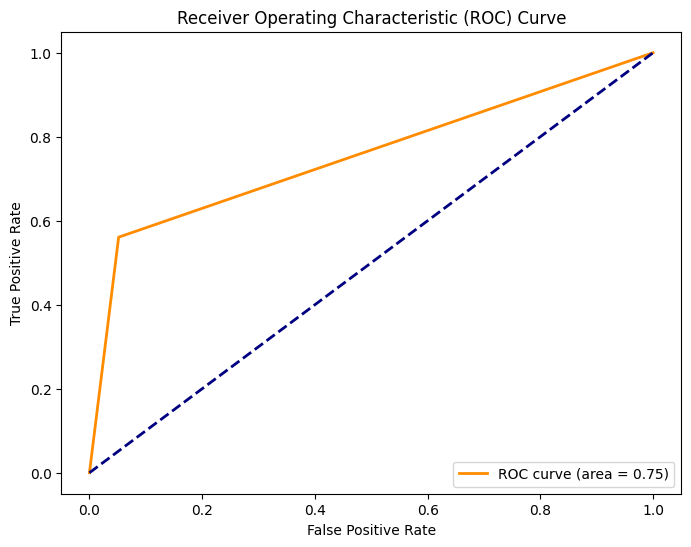

In [16]:
# 정밀도
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# 재현율
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# F1 점수
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc:.2f}')

# 분류 리포트
target_names = ['normal', 'abnormal']
print(classification_report(y_test, y_pred, target_names=target_names))

# ROC 곡선
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [17]:
# 모델 저장
model.save('final_model.keras')